In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
import yaml
import sys
import glob
import os
%matplotlib inline

sns.set(font_scale=1.2)
sns.set_style("white")

In [44]:
def sum_cpu(node_res):
    """Return sum of CPU resources allocated to all nodes"""
    cpu = sum([v['cpu'] for v in node_res])
    return cpu

def read_placement(placement, df_data, num_flows):
    """Read placement dict and write it to df_data. Then return."""
    df_data['num_flows'].append(num_flows)
    df_data['num_sources'].append(placement['input']['num_sources'])
    df_data['num_instances'].append(placement['metrics']['num_instances'])
    df_data['max_e2e_delay'].append(placement['metrics']['max_endToEnd_delay'])
    df_data['total_delay'].append(placement['metrics']['total_delay'])
    df_data['runtime'].append(placement['metrics']['runtime'])
    df_data['total_cpu'].append(sum_cpu(placement['placement']['alloc_node_res']))
    return df_data

def read_results(results):
    """Read result files matching the pattern and return df containing their metrics"""
    data = {'num_sources' : [], 'num_flows': [], 'num_instances': [], 'max_e2e_delay': [],
            'total_delay': [], 'runtime': [], 'total_cpu': []}

    # iterate through result files
    # WARNING: num flows is tailored to exactly my setup, where num flows increases by 1
    num_flows = 1
    for res in glob.glob(results):
        # open and save metrics of interest
        with open(res, 'r') as f:
            placement = yaml.load(f)
            data = read_placement(placement, data, num_flows)
            num_flows += 1

    return pd.DataFrame(data)

In [45]:
# read results
results = 'placement_data/synth_data/single_source/'

df_true = read_results(results + 'true/*.yaml')
df_fixed = read_results(results + 'fixed/*.yaml')
df_linear = read_results(results + 'linear/*.yaml')
df_boost = read_results(results + 'boosting/*.yaml')

df_boost

,num_sources,num_flows,num_instances,max_e2e_delay,total_delay,runtime,total_cpu
0,1,1,4,30,30,1.692804,0.928927
1,1,2,4,33,33,1.571339,2.969433
2,1,3,7,33,66,2.316807,3.898360
3,1,4,7,36,70,2.032080,5.938866
4,1,5,10,36,110,2.667869,6.867793


In [56]:
def plot(x_col, x_label, y_col, y_label):
    fig, ax = plt.subplots()
    
    plt.plot(df_true[x_col], df_true[y_col], label='True', color='black', marker='o')
    plt.plot(df_fixed[x_col], df_fixed[y_col], label='Fixed', color='green', marker='+')
    plt.plot(df_linear[x_col], df_linear[y_col], label='Linear', color='blue', marker='x')
    plt.plot(df_boost[x_col], df_boost[y_col], label='Boosting', color='red', marker='^')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(df_true[x_col])
    plt.legend()
    
    fig.savefig(f'plots/synth_{y_col}.pdf')

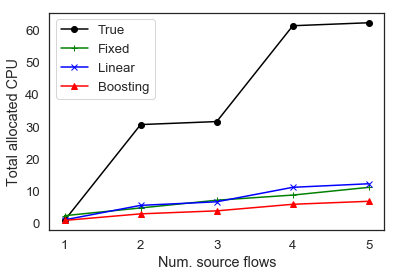

In [61]:
# FIXME: once the traffic load is above 6.5, ie, outside the training data set
# all models perform really poorly and don't go above 1

# TODO: make sure source traffic stays within the trained traffic range
# TODO: address this issue in paper somehow?
plot('num_flows', 'Num. source flows', 'total_cpu', 'Total allocated CPU')

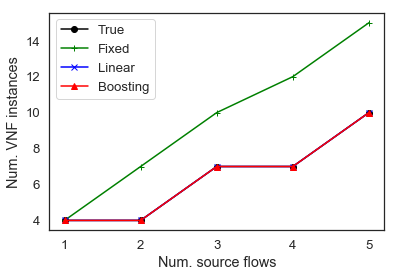

In [58]:
plot('num_flows', 'Num. source flows', 'num_instances', 'Num. VNF instances')

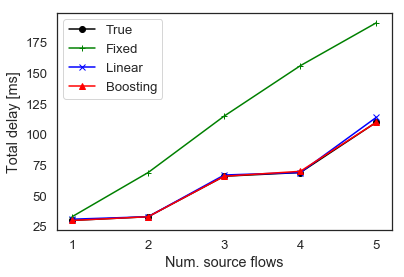

In [59]:
# FIXME: why is total delay lower than max e2e delay?
plot('num_flows', 'Num. source flows', 'total_delay', 'Total delay [ms]')

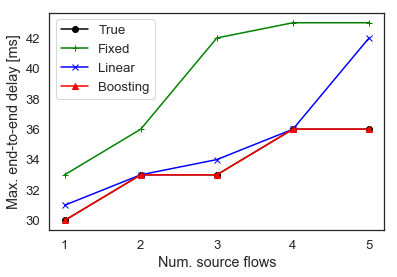

In [60]:
plot('num_flows', 'Num. source flows', 'max_e2e_delay', 'Max. end-to-end delay [ms]')